In [ ]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pywt

# Data Loading

In [1]:
#prepare data
sample_data_raw_file = "./SN001.edf"
raw = mne.read_raw_edf(sample_data_raw_file, preload=True)
annot = mne.read_annotations("./SN001_sleepscoring.edf")
raw.set_annotations(annot)

# 채널 타입을 설정하기 위한 사전 정의
channel_types = {
    raw.ch_names[0]: 'eeg',  # 인덱스 0
    raw.ch_names[1]: 'eeg',  # 인덱스 1
    raw.ch_names[2]: 'eeg',  # 인덱스 2
    raw.ch_names[3]: 'eeg',  # 인덱스 3
    raw.ch_names[4]: 'emg',  # 인덱스 4, EMG chin
    raw.ch_names[5]: 'eog',  # 인덱스 5, EOG
    raw.ch_names[6]: 'eog',  # 인덱스 6, EOG
    raw.ch_names[7]: 'ecg'   # 인덱스 7, ECG
}
raw.set_channel_types(channel_types)

# 원본 데이터 복사 및 저장
original_data = raw.copy()

raw_eog = original_data.copy().pick(picks='eog')

Extracting EDF parameters from /Users/hoho/dev/EEG_analysis/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


# Filtering

In [2]:
#filtering
eog_filt = raw_eog.copy().filter(0.2,35,picks='eog')

#notchFilter
eog_bf = eog_filt.copy().notch_filter(50,picks='eog')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4225 samples (16.504 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


# Denoising (Discrete Wavelet Transform)

In [3]:
# Function to perform wavelet denoising
def wavelet_denoise(data, wavelet, level):
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    sigma = (1/0.6745) * mad(coeff[-level])
    
    # Threshold for each detail coefficient
    uthresh = sigma * np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

# Median Absolute Deviation: a robust measure of variability
def mad(data, axis=None):
    return np.median(np.abs(data - np.median(data, axis)), axis)


eog_data0 = eog_bf.copy().get_data(picks=[0]).squeeze()
# Perform denoising
eog_data_dn = wavelet_denoise(eog_data0, 'db4', level=4)
#fit in data
raw._data[5] = eog_data_dn[np.newaxis, :]

eog_data1 = eog_bf.copy().get_data(picks=[1]).squeeze()
# Perform denoising
eog_data_dn = wavelet_denoise(eog_data1, 'db4', level=4)
#fit in data
raw._data[6] = eog_data_dn[np.newaxis, :]

In [4]:
eog = raw.copy().pick(picks='eog') # pick preprocessed eog signal
eog_orig = original_data.copy().pick(picks='eog') # pick raw eog signal

# Plot and Comapare

Using matplotlib as 2D backend.


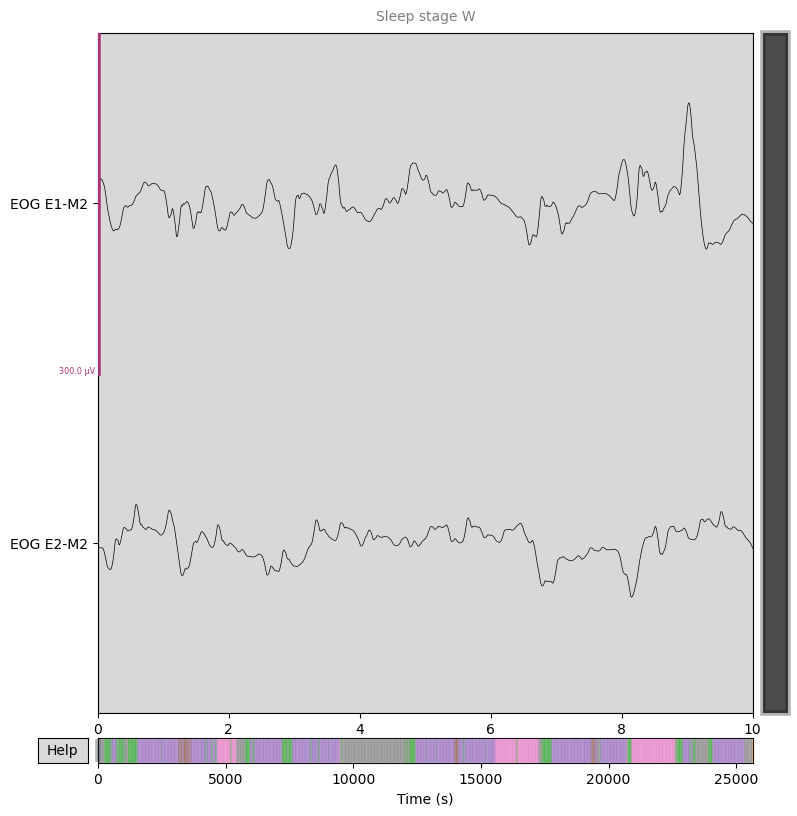

In [5]:
eog.plot(duration=10);

## Resample

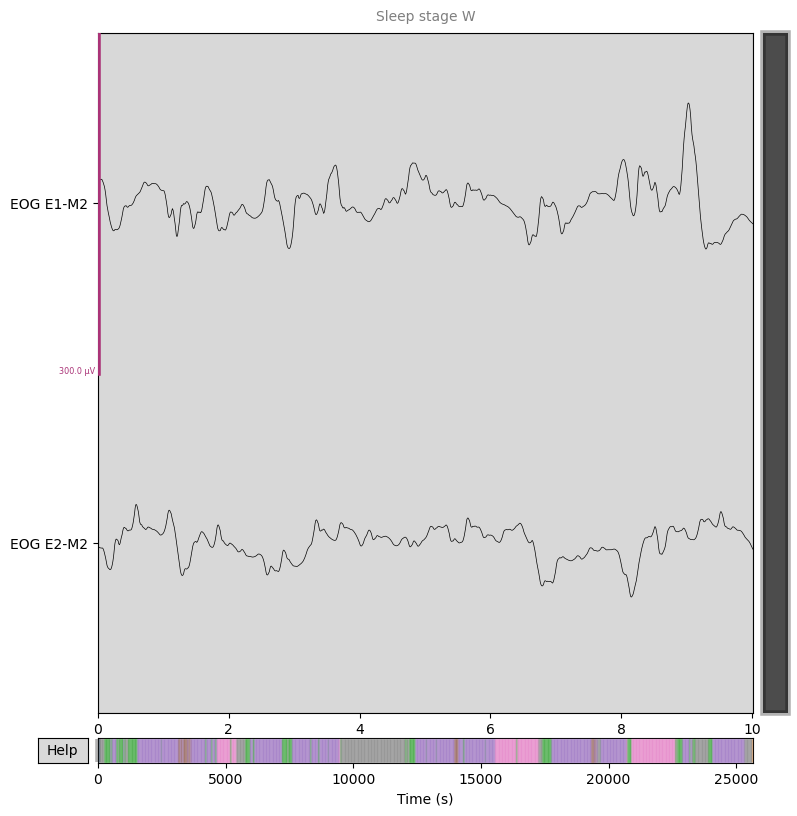

In [6]:
raw.resample(100) # resample by 100Hz
eog_100 = raw.copy().pick(picks='eog')
eog_100.plot(duration=10);

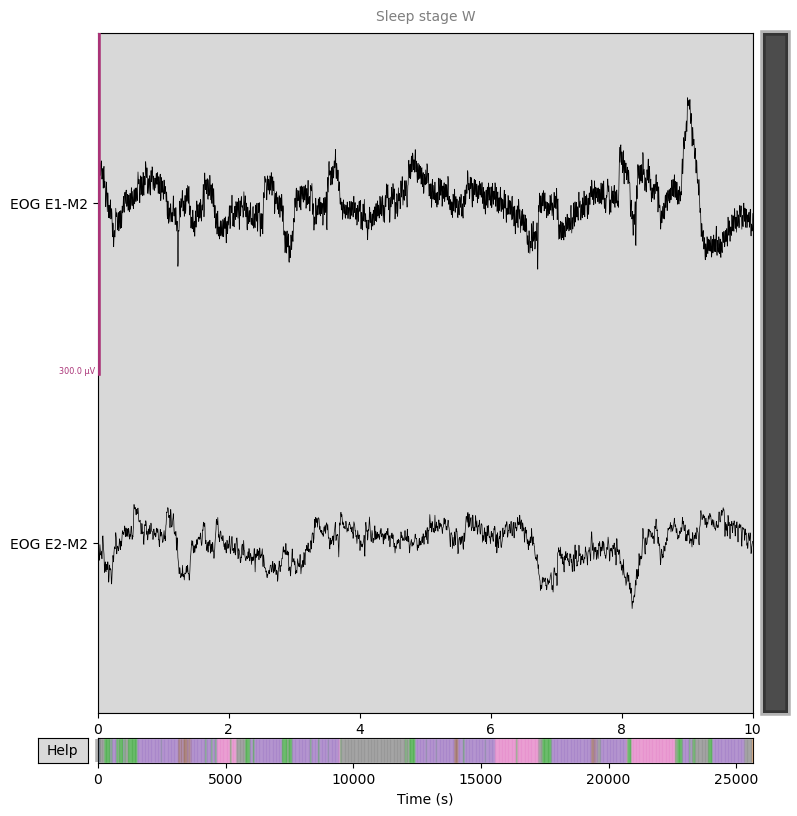

In [7]:
eog_orig.plot(duration=10);